0% Done
10% Done
20% Done
30% Done
40% Done
50% Done
59% Done
69% Done
79% Done
89% Done
99% Done


C:\Users\chris\AppData\Local\Temp\ipykernel_50604\3838348451.py:421: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


Total Time:  52.28791356086731  seconds


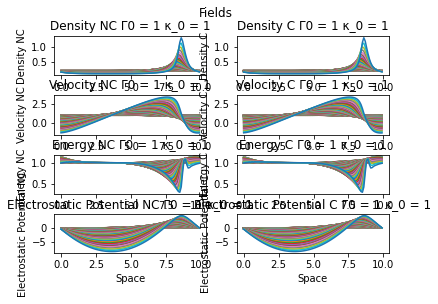

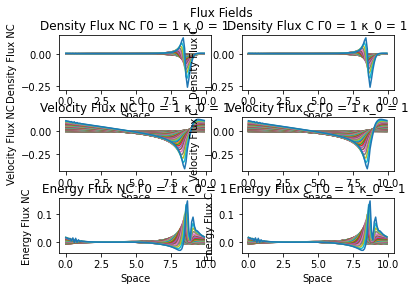

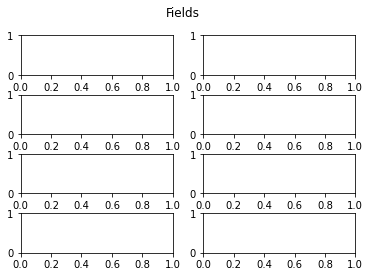

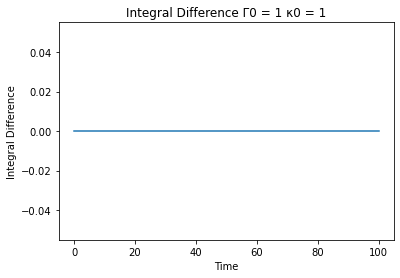

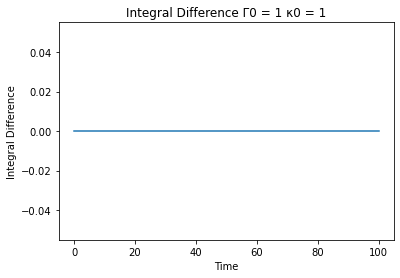

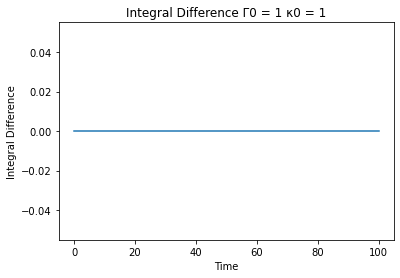

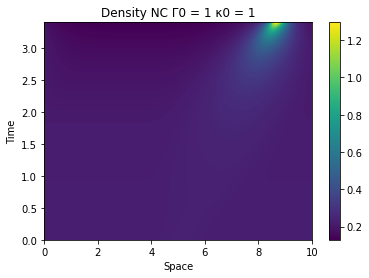

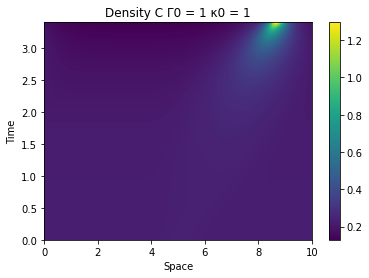

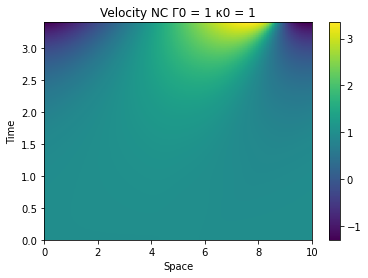

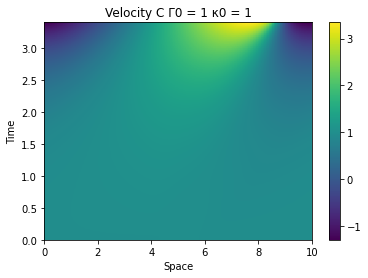

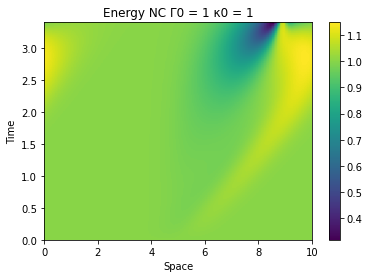

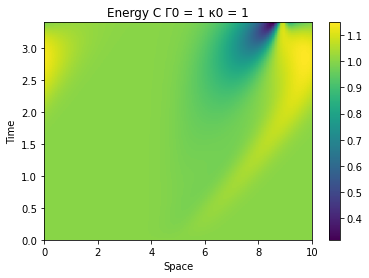

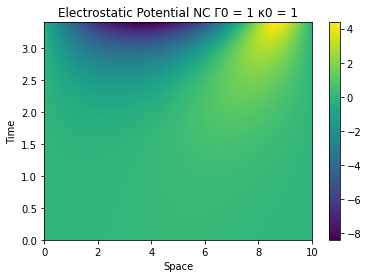

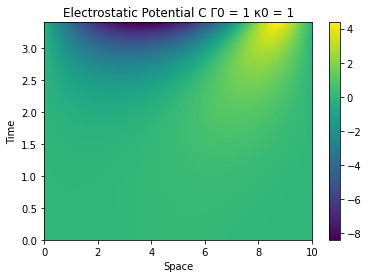

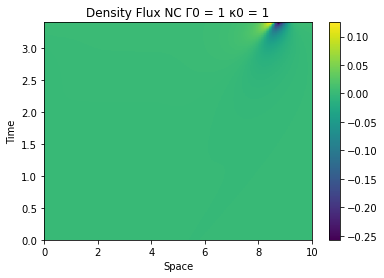

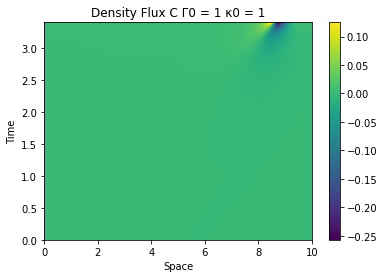

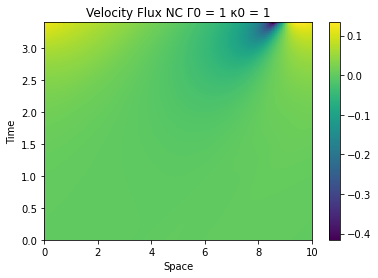

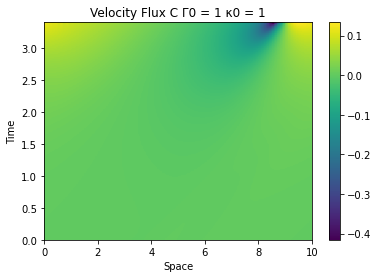

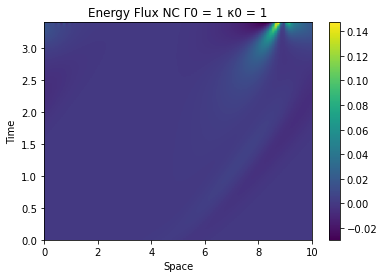

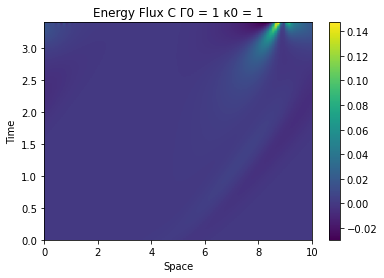

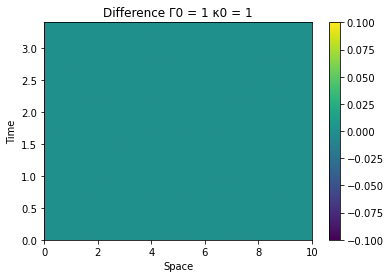

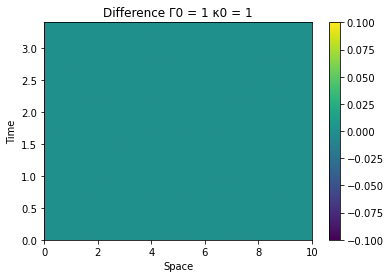

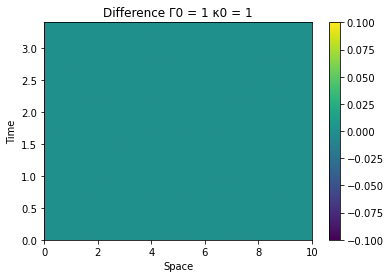

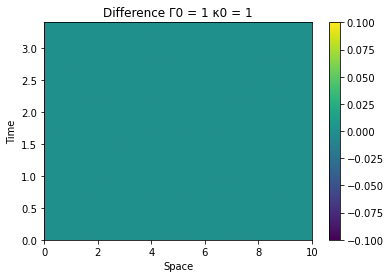

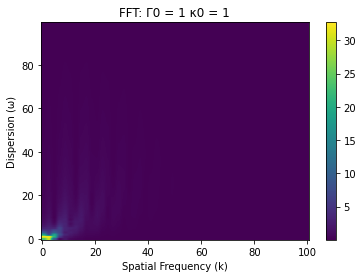

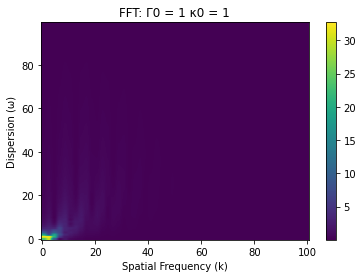

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack as scifft
import scipy.integrate as sciint
import time

# Space Domain
Xpts = int(1e2)
Xlngth = 10
dx = Xlngth / Xpts
X = np.linspace(0, Xlngth - dx, Xpts)

# Time Domain
Tpts = int(1e2) + 1
Tlngth = 3.4  # .212
T = np.linspace(0, Tlngth, Tpts)[:-1]
dt = Tlngth / (Tpts - 1)

lmbd = dt / dx

# Snapshots
snaps = 100 + 1
cursnap = 0
Y = np.linspace(0, Tlngth, snaps)
xx, yy = np.meshgrid(X, Y, sparse=False, indexing='xy')

# Spatial Frequency Domain
k_fft_norm = 2 * np.pi / (Xpts * dx)
k = k_fft_norm * np.linspace(-Xpts / 2, Xpts / 2 - 1, Xpts)

# Integration Domain/Extensions
num_dom_ext = 5
Xppts = int(num_dom_ext * Xpts)
Wlngth = 10
Wpts = 100
dw = Wlngth / Wpts

Xp = np.linspace(-int((Xpts - 1) / 2), int((Xpts + 1) / 2), Xppts)  # grid points in x'
Wp = np.linspace(0, Wlngth, Wpts) + dw  # grid points in w'; right endpoint  theoretically goes to infinity

# Parameters
mean_n = 3 / (4 * np.pi)
Gamma_0 = 1
kappa_0 = 1
therm_cond = .01
q = 1

# Memory Allocation
n, ntot, nint, nflux, nfluxtot = np.zeros((2, Xpts)), np.zeros((snaps, 2, Xpts)), np.zeros((snaps, 2)), \
                                 np.zeros((2, Xpts)), np.zeros((snaps, 2, Xpts))
v, vtot, vint, vflux, vfluxtot = np.zeros((2, Xpts)), np.zeros((snaps, 2, Xpts)), np.zeros((snaps, 2)), \
                                 np.zeros((2, Xpts)), np.zeros((snaps, 2, Xpts))
e, etot, eint, eflux, efluxtot = np.zeros((2, Xpts)), np.zeros((snaps, 2, Xpts)), np.zeros((snaps, 2)), \
                                 np.zeros((2, Xpts)), np.zeros((snaps, 2, Xpts))
phi, phimtx, phitot = np.zeros((2, Xpts)), np.zeros((2, Xpts)), np.zeros((snaps, 2, Xpts))

# Memory Allocation - Correlations
n_p = np.zeros(Xppts)
beta_p = np.zeros(Xppts)

n_x_p = np.zeros((Xpts, Xppts))
beta_x_p = np.zeros((Xpts, Xppts))

n_p_wp = np.zeros((Xpts, Xppts, Wpts))
beta_p_wp = np.zeros((Xpts, Xppts, Wpts))

u_potential = np.zeros((Xpts, Xppts, Wpts))
corr_integrand = np.zeros((Xpts, Xppts, Wpts))

# Initial Condition
ICchoice = np.array([0, 0, 3])  # Gaussian = 0, Wave = 1, Random = 2, Constant = 3, Zero = 4
perturb_ampltd = [.01, .01, .01]
gaus_lngth = .05 * Xlngth
IC_freq = 2 * np.pi / Xlngth
ICdict = np.array([
    np.array([
        mean_n * np.ones(Xpts) + perturb_ampltd[0] * np.exp(-((X - Xlngth/2) ** 2) / (2 * gaus_lngth ** 2)) - perturb_ampltd[0] * np.sqrt(2 * np.pi) * gaus_lngth,
        mean_n * np.ones(Xpts) + perturb_ampltd[0] * np.cos(3 * IC_freq * X),
        mean_n * np.ones(Xpts) + perturb_ampltd[0] * np.random.random(Xpts),
        mean_n * np.ones(Xpts),
        np.zeros(Xpts)
    ]),
    np.array([
        np.ones(Xpts) + perturb_ampltd[1] * np.exp(-((X - Xlngth/2) ** 2) / (2 * gaus_lngth ** 2)) - perturb_ampltd[1] * np.sqrt(2 * np.pi) * gaus_lngth,
        np.zeros(Xpts) + perturb_ampltd[1] * np.cos(3 * IC_freq * X),
        np.zeros(Xpts) + perturb_ampltd[1] * np.random.random(Xpts),
        np.ones(Xpts),
        np.zeros(Xpts)
    ]),
    np.array([
        np.ones(Xpts) + perturb_ampltd[2] * np.exp(-((X - Xlngth/2) ** 2) / (2 * gaus_lngth ** 2)) - perturb_ampltd[2] * np.sqrt(2 * np.pi) * gaus_lngth,
        np.zeros(Xpts) + perturb_ampltd[2] * np.cos(3 * IC_freq * X),
        np.zeros(Xpts) + perturb_ampltd[2] * np.random.random(Xpts),
        np.ones(Xpts),
        np.zeros(Xpts)
    ])
])

n[:] = ICdict[0, ICchoice[0]]
v[:] = ICdict[1, ICchoice[1]]
e[:] = ICdict[2, ICchoice[2]]


# Shift to Left
def l(array):  # Has Been Checked
    return np.roll(array, 1, axis=-1)


# Shift to Right
def r(array):  # Has Been Checked
    return np.roll(array, -1, axis=-1)


# Derivative
def ddx(array):  # Has Been Checked
    return (array - l(array)) / dx


# Second Derivative
def d2dx2(array):  # Has Been Checked
    return (r(array) - 2 * array + l(array)) / (dx * dx)


# Check Nans
def checknan(array, name, time):
    if np.isnan(array.any()):
        print("Nan value at " + name + " at tt = " + str(time))
        return True
    return False


# Take Snapshot
def savesnap(cursnap):
    ntot[cursnap] = n
    vtot[cursnap] = v
    etot[cursnap] = e
    phitot[cursnap] = phi
    nfluxtot[cursnap] = nflux
    vfluxtot[cursnap] = vflux
    efluxtot[cursnap] = eflux
    nint[cursnap] = np.trapz(n, X)
    vint[cursnap] = np.trapz(v, X)
    eint[cursnap] = np.trapz(e, X)


# Solve Phi
def solvephi(den):
    phi = np.zeros((2, Xpts))
    # phimtx * phi = b
    # Define b
    b = 3 - 4 * np.pi * dx * dx * den
    b = b - np.mean(b)
    # First sweep
    phimtx[:, 0] = -0.5
    b[:, 0] = -0.5 * b[:, 0]
    for ii in range(1, Xpts - 1):
        phimtx[:, ii] = -1 / (2 + phimtx[:, ii - 1])
        b[:, ii] = (b[:, ii - 1] - b[:, ii]) / (2 + phimtx[:, ii - 1])
    # Second sweep
    phi[:, 0] = b[:, Xpts - 1] - b[:, Xpts - 2]
    for ii in range(1, Xpts - 1):  # TODO: CHECK INDICES
        phi[:, ii] = (b[:, ii - 1] - phi[:, ii - 1]) / phimtx[:, ii - 1]

    return phi


def fft_correlations(ncorr, Gamma, kappa):
    delta_n = ncorr - mean_n
    fhat = np.fft.fftshift(np.fft.fft(delta_n))
    dcfunc = 4 * np.pi * Gamma / (k ** 2 + kappa ** 2)

    conv = fhat * dcfunc
    conv = np.fft.ifft(np.fft.ifftshift(conv))
    conv = np.real(conv)

    return conv


def meyer_correlations(den, temp):
    # Periodic Function Extensions - Extend x to x'
    # Shape: (Xppts,)
    n_p = np.tile(den, num_dom_ext)
    beta_p = np.tile(1 / temp, num_dom_ext)
    # print(n_p.shape)
    # print(beta_p.shape)

    # Extend x and x' to (x,x')
    # Shape: (Xpts, Xppts)
    n_x_p = np.subtract.outer(den, n_p) - mean_n
    beta_x_p = np.stack([beta_p] * Xpts, axis=0)

    # Extend (x,x') to (x,x',w')
    # Shape: (Xpts, Xppts, Wpts)
    n_p_wp = np.stack([n_x_p] * Wpts, axis=1)
    beta_p_wp = np.stack([beta_x_p] * Wpts, axis=1)

    # Define Potential and Correlation Integrand
    # Shape: (Xpts, Xppts, Wpts)
    u_potential = beta_p_wp * (1 / Wp)[:, None]
    corr_integrand = (1 - np.exp(-q ** 2 * u_potential)) * (ddx(beta_p_wp) - u_potential * Xp)

    # Calculate full integral
    corr_integrand = n_p_wp * corr_integrand
    first_int = np.trapz(corr_integrand, axis=-1, dx=dx)  # Integrate over x'
    res = np.trapz(first_int, axis=-1, dx=dw)  # Integrate over w'

    # Check if integrand has Nan values
    if np.isnan(corr_integrand.any()):
        print(np.argwhere(np.isnan(corr_integrand)))
        exit()

    return res

def set_values_to_average(arr):
    """
    Sets the value of elements in a 1D array to the average of their neighbors
    when the value is less than 0 or greater than 1.

    Args:
    - arr: a numpy array

    Returns:
    - None (the input array is modified in place)
    """
    # Get the size of the array
    n = arr.size

    # Loop over each element of the array
    for i in range(n):
        # Check if the current element is less than 0 or greater than 1
        if arr[i] < 0 or arr[i] > 1:
            # Get the indices of the neighbors
            indices = [i-1, i+1]

            # Filter out the out-of-bounds indices
            valid_indices = [j for j in indices if j>=0 and j<n]

            # Compute the average of the neighbors
            num_neighbors = len(valid_indices)
            if num_neighbors > 0:
                neighbor_sum = sum(arr[j] for j in valid_indices)
                neighbor_avg = neighbor_sum / num_neighbors
            else:
                neighbor_avg = 0

            # Set the value of the current element to the average of its neighbors
            arr[i] = neighbor_avg

start = time.time()
for tt in range(Tpts):

    n[1] = n[0]
    v[1] = v[0]
    e[1] = e[0]

    phi = solvephi(n)

    # Flux
    # nflux = dt * ddx(n * v)
    # vflux = dt * (ddx(e + .5 * v * v))
    # eflux = dt * (e * ddx(v) + ddx(v * e) - therm_cond * ddx(np.log(n)) * ddx(e) - ddx(therm_cond * ddx(r(e))))
    nflux = dt * ddx(n * v)
    vflux = dt * (ddx(.5*v*v) + e*ddx(n)/n - Gamma_0*ddx(phi))
    eflux = dt * (2*v*ddx(e) + v*e*ddx(n)/n - (therm_cond/(3*n))*d2dx2(e))

    # Correlations
    vcorr = np.zeros((2, Xpts))
    vcorr[1] = dt*e[1]*ddx(meyer_correlations(n[1], e[1]))

    # Store Values
    if (tt % int(Tpts / (snaps - 1))) == 0:
        savesnap(cursnap)
        cursnap += 1

    # Solve
    n = n - nflux
    v = v - vflux - vcorr
    e = e - eflux

    # Check Nans
    ncheck, vcheck, echeck = checknan(n, "n", tt), checknan(v, "n", tt), checknan(e, "n", tt)
    nfluxcheck, vfluxcheck, efluxcheck = checknan(nflux, "n", tt), checknan(vflux, "n", tt), checknan(eflux, "n", tt)
    if ncheck or vcheck or echeck or nfluxcheck or vfluxcheck or efluxcheck:
        exit()

    # Track Progress
    if tt % int(Tpts / 10) == 0:
        print(str(round(100 * tt / Tpts)) + "% Done")
end = time.time()


def data_visualize(*args):  # Has Been Checked
    sys_data_to_visualize = np.array([np.swapaxes(array, 0, 1) for array in args])
    return sys_data_to_visualize


def data_names(var_name, *args):
    cornames = ["NC", "C"]
    if var_name.strip():
        var_name = " " + var_name
    names = np.array([np.array([name + var_name + " " + corname for corname in cornames]) for name in args])
    return names


# Reformat data for plotting
syssnap = data_visualize(ntot, vtot, etot, phitot)  # Shape: (4, 2, Tpts, Xpts)
syssnapflux = data_visualize(nfluxtot, vfluxtot, efluxtot)  # Shape: (3, 2, Tpts, Xpts)
syssnapint = data_visualize(nint, vint, eint)  # Shape: (3, 2, Tpts)

syssnapname = data_names("", "Density", "Velocity", "Energy", "Electrostatic Potential")
syssnapfluxname = data_names("Flux", "Density", "Velocity", "Energy")
syssnapintname = data_names("Integral", "Density", "Velocity", "Energy")


# Plotting
def plot_snaps(data, name, xaxis, yaxis):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    for kk in range(len(data)):
        ax.plot(X, data[kk], label="T = " + str(round(kk * dt * Tlngth / snaps, 2)))
    ax.set_title(name + " Γ0 = " + str(Gamma_0) + " κ_0 = " + str(kappa_0))
    ax.set_xlabel(xaxis)
    ax.set_ylabel(yaxis)
    ax.legend()

    return ax


syssnap_eq, syssnap_cor, syssnap_time, syssnap_lngth = syssnap.shape
syssnapflux_eq, syssnapflux_cor, syssnapflux_time, syssnapflux_lngth = syssnapflux.shape
syssnapint_eq, syssnapint_cor, syssnapint_time = syssnapint.shape

# Plot Fields
syssnapplots = [[0 for ii in range(syssnap_cor)] for jj in range(syssnap_eq)]
# for ii in range(syssnap_eq):
#     for jj in range(syssnap_cor):
#         syssnapplots[ii][jj] = plot_snaps(syssnap[ii, jj], syssnapname[ii, jj], "Space", syssnapname[ii, jj])

# Plot Fluxes
# syssnapfluxplots = []
# for ii in range(syssnapflux_eq):
#     for jj in range(syssnapflux_cor):
#         plot_snaps(syssnapflux[ii, jj], syssnapfluxname[ii, jj], "Space", syssnapfluxname[ii, jj])


# Subplot: Individual Fields
def subplot(data, name, xaxis, title):
    row, col, plot, _ = data.shape
    fig, axs = plt.subplots(row, col)
    for ii in range(row):
        for jj in range(col):
            for kk in range(plot):
                axs[ii, jj].plot(X, data[ii, jj, kk], label="T = " + str(round(kk * dt * Tlngth / snaps, 2)))
            axs[ii, jj].set_title(name[ii, jj] + " Γ0 = " + str(Gamma_0) + " κ_0 = " + str(kappa_0))
            axs[ii, jj].set_xlabel(xaxis[ii][jj])
            axs[ii, jj].set_ylabel(name[ii][jj])
    plt.subplots_adjust(hspace=0.5)
    fig.suptitle(title)


subplot(syssnap, syssnapname, [["Space" for jj in range(syssnap_cor)] for ii in range(syssnap_eq)], "Fields")

subplot(syssnapflux, syssnapfluxname, [["Space" for jj in range(syssnapflux_cor)] for ii in range(syssnapflux_eq)], "Flux Fields")


# Subplots: Compile Plots Using Axes
def subplot_plots(plots, title):
    row = len(plots)
    col = max(len(plots[ii]) for ii in range(row))
    fig, axs = plt.subplots(row, col)
    for ii in range(row):
        for jj in range(col):
            axs[ii, jj] = plots[ii][jj]
    plt.subplots_adjust(hspace=0.5)
    fig.suptitle(title)


subplot_plots(syssnapplots, "Fields")

# subplot_plots(syssnapfluxplots, "Flux Fields")


# Subplot: Color Plots
def subplot_imshow(data, name, xaxis, title):
    row, col, plot, _ = data.shape
    fig, axs = plt.subplots(row, col)
    for ii in range(row):
        for jj in range(col):
            for kk in range(plot):
                axs[ii, jj].plot(X, data[ii, jj, kk], label="T = " + str(round(kk * dt * Tlngth / snaps, 2)))
            axs[ii, jj].set_title(name[ii, jj] + " Γ0 = " + str(Gamma_0) + " κ_0 = " + str(kappa_0))
            axs[ii, jj].set_xlabel(xaxis[ii][jj])
            axs[ii, jj].set_ylabel(name[ii][jj])
    plt.subplots_adjust(hspace=0.5)
    fig.suptitle(title)


# Plot Integrals, Ensure Conservation
def plot_conserved(data, name):
    plt.figure()
    plt.plot(np.arange(snaps), data)
    plt.title(name + " Γ0 = " + str(Gamma_0) + " κ0 = " + str(kappa_0))
    plt.xlabel("Time")
    plt.ylabel(name)


# Plots: Conservation of Fields
# for ii in range(len(syssnapint)):
#     for jj in range(len(syssnapint[ii])):
#         plot_conserved(syssnapint[ii, jj], syssnapintname[ii, jj])

# Plots: Difference of Fields Over Time
for ii in range(len(syssnapint)):
    plot_conserved(syssnapint[ii, 0] - syssnapint[ii, 1], "Integral Difference")

# subplot(syssnapint, syssnapintname, [["Time" for jj in range(syssnapint_cor)] for ii in range(syssnapint_eq)])


# ImShow
def imshow(data, name, xaxis, yaxis):
    plt.figure()
    clr = plt.imshow(data, aspect='auto', origin='lower', extent=(0, Xlngth, 0, Tlngth))
    plt.colorbar()
    plt.title(name + " Γ0 = " + str(Gamma_0) + " κ0 = " + str(kappa_0))
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)


# Color Plots: Fields
for ii in range(len(syssnap)):
    for jj in range(len(syssnap[ii])):
        imshow(syssnap[ii, jj], syssnapname[ii, jj], "Space", "Time")

# Color Plots: Fields
for ii in range(len(syssnapflux)):
    for jj in range(len(syssnapflux[ii])):
        imshow(syssnapflux[ii, jj], syssnapfluxname[ii, jj], "Space", "Time")

# Color Plots: Differences
for ii in range(len(syssnap)):
    imshow(syssnap[ii, 0] - syssnap[ii, 1], "Difference", "Space", "Time")

# FFT
nsnap = syssnap[0]
for ii in range(len(nsnap)):
    n_fft = nsnap[ii] - np.mean(nsnap[ii])
    n_fft = np.swapaxes(n_fft, 0, 1)

    n_fft_flip = np.flip(n_fft, axis=1)
    n_fft = np.hstack((n_fft, n_fft_flip))

    fft = np.fft.fft2(n_fft, axes=(0, 1))
    fft = np.fft.fftshift(fft, axes=(0, 1))
    fft = np.transpose(fft)

    # Reflect
    fftlength0, fftlength1 = fft.shape
    fft1_1st_half, fft1_2nd_half = fft[:int(fftlength0 / 2)], fft[int(fftlength0 / 2):]
    reflect1 = (np.flip(fft1_1st_half, axis=0) + fft1_2nd_half) / 2  # Reflect Bottom -> Up
    reflect1_1st_half, reflect1_2nd_half = reflect1[:, :int(fftlength1 / 2)], reflect1[:, int(fftlength1 / 2):]
    fft_avg = (np.flip(reflect1_1st_half, axis=1) + reflect1_2nd_half) / 2  # Reflect Left -> Right

    # Plot FFT
    plt.figure()
    plt.imshow(np.abs(fft_avg), aspect='auto', origin='lower', extent=(-0.5, snaps - 0.5, -0.5, Xpts - 0.5))
    plt.colorbar()
    plt.xlabel("Spatial Frequency (k)")
    plt.ylabel("Dispersion (ω)")
    plt.title("FFT: Γ0 = " + str(Gamma_0) + " κ0 = " + str(kappa_0))

end = time.time()
print("Total Time: ", end - start, " seconds")
# print("Off By:", np.round(100*(end - start - (elapsed_time * T / 100))/(end - start), 2), " %")

plt.show()

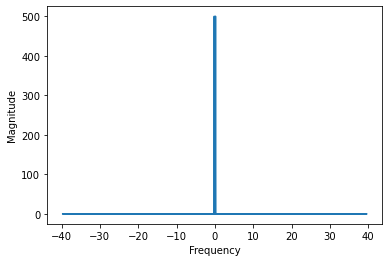

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function to transform
def my_func(x):
    return np.sin(x)

# Define the range of x values
x_min = 0
x_max = 4*np.pi
num_points = 1000
x_vals = np.linspace(x_min, x_max, num_points)

# Calculate the Fourier transform of the function
fft_vals = np.fft.fft(my_func(x_vals))

# Calculate the frequency values
dx = x_vals[1] - x_vals[0]
freq_vals = np.fft.fftfreq(num_points, dx)

# Plot the Fourier transform
plt.plot(freq_vals, np.abs(fft_vals))
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.show()

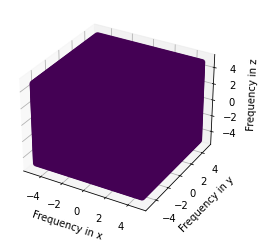

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the function to transform
def my_func(x, y, z):
    return np.exp(-(x**2 + y**2 + z**2))

# Define the range of x, y, and z values
x_min = y_min = z_min = -5
x_max = y_max = z_max = 5
num_points = 100
x_vals = np.linspace(x_min, x_max, num_points)
y_vals = np.linspace(y_min, y_max, num_points)
z_vals = np.linspace(z_min, z_max, num_points)
X, Y, Z = np.meshgrid(x_vals, y_vals, z_vals)

# Evaluate the function at each point in the grid
f = my_func(X, Y, Z)

# Calculate the 3D Fourier transform of the function
F = np.fft.fftn(f)

# Calculate the frequency values
dx = dy = dz = x_vals[1] - x_vals[0]
freq_vals = np.fft.fftfreq(num_points, dx)

# Plot the magnitude of the Fourier transform
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
Xf, Yf, Zf = np.meshgrid(freq_vals, freq_vals, freq_vals)
ax.scatter(Xf.ravel(), Yf.ravel(), Zf.ravel(), c=np.abs(F).ravel(), cmap='viridis')
ax.set_xlabel('Frequency in x')
ax.set_ylabel('Frequency in y')
ax.set_zlabel('Frequency in z')
plt.show()